In [1]:
import pandas as pd
import numpy as np
import matplotlib
import scipy as sp
import sklearn

import IPython
from IPython import display

#misc libraries
import random
import time

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

-------------------------


In [2]:
#common model algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier


In [3]:
#common model helpers
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

In [4]:
#visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize']=12,8


In [5]:
data_raw = pd.read_csv('/Users/hrishkeshhandique/Desktop/python projects/Titanic- ML from Disaster/titanic/train.csv')

data_val = pd.read_csv('/Users/hrishkeshhandique/Desktop/python projects/Titanic- ML from Disaster/titanic/test.csv')

#creating a copy to play with the data
data1 = data_raw.copy(deep = True)

data_cleaner = [data1, data_val]

#preview data
data_raw.info()

data_raw.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
588,589,0,3,"Gilinski, Mr. Eliezer",male,22.0,0,0,14973,8.0500,NaN,S
782,783,0,1,"Long, Mr. Milton Clyde",male,29.0,0,0,113501,30.0000,D6,S
84,85,1,2,"Ilett, Miss. Bertha",female,17.0,0,0,SO/C 14885,10.5000,NaN,S
212,213,0,3,"Perkin, Mr. John Henry",male,22.0,0,0,A/5 21174,7.2500,NaN,S
437,438,1,2,"Richards, Mrs. Sidney (Emily Hocking)",female,24.0,2,3,29106,18.7500,NaN,S
109,110,1,3,"Moran, Miss. Bertha",female,NaN,1,0,371110,24.1500,NaN,Q
101,102,0,3,"Petroff, Mr. Pastcho (""Pentcho"")",male,NaN,0,0,349215,7.8958,NaN,S
787,788,0,3,"Rice, Master. George Hugh",male,8.0,4,1,382652,29.1250,NaN,Q
15,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
93,94,0,3,"Dean, Mr. Bertram Frank",male,26.0,1,2,C.A. 2315,20.5750,NaN,S


Once we read the data we need to clean it. 4C's of data cleaning:

1. Correcting: Reviewing the data if there's any aberrant or non acceptable data inputs. If there are unresonable values like age = 800 instead of 80, then it's probably a safe decision to fix. However, we want to use caution when we modify data from its original value becuase it may be necessary to create an accurate model.

2. Completing: There are null values or missing data which can be bad because some algorithms don't know how to handle null values and will fail. Thus it's important to fix before we start modeling because we will compare and contrast many different models. There are two methods, either delete the record or populate the missing value using a resonable input. It is not recommended to delete a record, especially a large percentage of record unless it truly reporesents an incomplete record. Instead  it's best to impute missing values. For basic qualitative data we can impute using mode. Also we can impute using mean,mdeian, or mean + randomized standard deviation. An intermediate way would be to use basic methodlogy based on specific criteria, like the average age by class or embark port by fare and SES. There are more complex methodologies, however before deploying, it should be compared to the base model to determine if complexity truly adds value. For this dataset, age will be imputed with median, the cabin attribute will be dropped, and embark will be imputed with mode. Subsequent model iterations may modify this decision to determine if it improves the model's accuracy.

3. Creating: Feature engineering is when we use existing features to create new features to determine if they provide new signals to predict the outcome. For this dataset we will create a title feature to determine if it played a role in survival

4. Converting: Lastly we will deal with formatting into datatype formats. Our categorial data is imported as objects which makes it difficult for mathematical calculations. For this dataset, we will convert object datatypes to categorial dummy variables.

In [6]:
print('Train columns with null values:\n',data1.isnull().sum())
print('-'*20)

print('Test columns with null values:\n',data_val.isnull().sum())
print('-'*20)

data_raw.describe(include = 'all')

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
--------------------
Test columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
--------------------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Sobey, Mr. Samuel James Hayden",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


Next step is to clean the data. Now that we know all the columns containing null or no values.

In [7]:
#completing or deleting missing values in train and test datasets

for dataset in data_cleaner:
    #complete missing age with median
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)
    
    #complete missing embark with mode. Since mode might contain muliple values we take the first mode
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)
    
    #comlpete missing fare with mdeian
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
    #delete the cabin coulmn and other previously stated dataset that is not important.
    drop_coulmn = ['PassengerId','Cabin','Ticket']
    
#axis=1 means columns and axis=0 means rows
data1.drop(drop_coulmn,axis=1, inplace = True)
    
print(data1.isnull().sum())
print("-"*10)
print(data_val.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [8]:
#Feature engineering for train and test dataset

for dataset in data_cleaner:
    #discrete variables
    dataset['FamilySize'] = dataset['SibSp']+dataset['Parch']+1
    
    dataset['IsAlone'] = 1
    
    #update is alone to 0 if family size is more than 1.
    dataset['IsAlone'].loc[dataset['FamilySize']>1]=0
    
    #quick and dirty split title from name
    dataset['Title'] = dataset['Name'].str.split(", ",expand=True)[1].str.split(".",expand=True)[0]
    
    #continous variable bins; qcut vs cut: 
    #qcuts will choose bins to be evenly spaced based on frequency while cuts uses based on values.
    #fare bins using qcuts
    dataset['FareBin'] = pd.qcut(dataset['Fare'],4)
    
    #age bins using cuts because it should be based on values
    #cut could convert ages to groups of age ranges
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int),5)
    
#clean up rare title names
#print(data1['Title'].value_counts())
stat_min = 10
#while small is arbitrary, we'll use the common minimum in statistics: http://nicholasjjackson.com/2012/03/08/sample-size-is-10-a-magic-number/

title_names = (data1['Title'].value_counts()<stat_min)
#this will create a true false series with title name as index

#apply and lambda functions are quick and dirty code to find and replace with fewer lines of code: https://community.modeanalytics.com/python/tutorial/pandas-groupby-and-python-lambda-functions/
data1['Title'] = data1['Title'].apply(lambda x: 'Misc' if title_names.loc[x]==True else x)
print(data1['Title'].value_counts())
print('-'*20)
    
    

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64
--------------------


In [9]:
#preview data again
data1.info()
data_val.info()
data1.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Name          891 non-null object
Sex           891 non-null object
Age           891 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Embarked      891 non-null object
FamilySize    891 non-null int64
IsAlone       891 non-null int64
Title         891 non-null object
FareBin       891 non-null category
AgeBin        891 non-null category
dtypes: category(2), float64(2), int64(6), object(4)
memory usage: 85.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null in

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
50,0,3,"Panula, Master. Juha Niilo",male,7.0,4,1,39.6875,S,6,0,Master,"(31.0, 512.329]","(-0.08, 16.0]"
659,0,1,"Newell, Mr. Arthur Webster",male,58.0,0,2,113.2750,C,3,0,Mr,"(31.0, 512.329]","(48.0, 64.0]"
114,0,3,"Attalah, Miss. Malake",female,17.0,0,0,14.4583,C,1,1,Miss,"(14.454, 31.0]","(16.0, 32.0]"
419,0,3,"Van Impe, Miss. Catharina",female,10.0,0,2,24.1500,S,3,0,Miss,"(14.454, 31.0]","(-0.08, 16.0]"
444,1,3,"Johannesen-Bratthammer, Mr. Bernt",male,28.0,0,0,8.1125,S,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]"
170,0,1,"Van der hoef, Mr. Wyckoff",male,61.0,0,0,33.5000,S,1,1,Mr,"(31.0, 512.329]","(48.0, 64.0]"
823,1,3,"Moor, Mrs. (Beila)",female,27.0,0,1,12.4750,S,2,0,Mrs,"(7.91, 14.454]","(16.0, 32.0]"
372,0,3,"Beavan, Mr. William Thomas",male,19.0,0,0,8.0500,S,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]"
650,0,3,"Mitkoff, Mr. Mito",male,28.0,0,0,7.8958,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
115,0,3,"Pekoniemi, Mr. Edvard",male,21.0,0,0,7.9250,S,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]"


In [10]:
#now we convert categorial data to dummy variables for mathematical calculations using sklearn and pandas function
#converting objects to category using label encoder for train andt test datasets

#code categorical data
label = LabelEncoder()

for dataset in data_cleaner:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])
    
#define y variable aka target/outcome
Target = ['Survived']
    
#define x variables for original features aka feature selection
data1_x = ['Sex','Pclass','Embarked','Title','SibSp','Parch','Age','Fare','FamilySize','IsAlone']
    
data1_x_calc = ['Sex_Code','Pclass','Embarked_Code','Title_Code','SibSp','Parch','Age','Fare']
#for algorithm calc
    
data1_xy = Target + data1_x
print('Original X Y: ',data1_xy,'\n')

#define x variables for original w/bin features to remove continous variables
data1_x_bin = ['Sex_Code','Pclass','Embarked_Code','Title_Code','FamilySize','AgeBin_Code','FareBin_Code']
data1_xy_bin = Target + data1_x_bin
print('Bin X Y: ',data1_xy_bin, '\n')

#define x and y variables for dummy features original
data1_dummy = pd.get_dummies(data1[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy
print('Dummy X Y: ',data1_xy_dummy,'\n')

data1_dummy.head()


Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,0,1,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,0,1
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,0,1,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,0,1
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,0,1,0


In [11]:
#double check cleaned data

print('Train coulmns with null values: \n',data1.isnull().sum())
print('-'*20)

data1.info()
print('-'*20)

print('Test coulmns with null values: \n',data_val.isnull().sum())
print('-'*20)

data_val.info()
print('-'*20)

data_raw.describe(include = 'all')


Train coulmns with null values: 
 Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilySize       0
IsAlone          0
Title            0
FareBin          0
AgeBin           0
Sex_Code         0
Embarked_Code    0
Title_Code       0
AgeBin_Code      0
FareBin_Code     0
dtype: int64
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
Survived         891 non-null int64
Pclass           891 non-null int64
Name             891 non-null object
Sex              891 non-null object
Age              891 non-null float64
SibSp            891 non-null int64
Parch            891 non-null int64
Fare             891 non-null float64
Embarked         891 non-null object
FamilySize       891 non-null int64
IsAlone          891 non-null int64
Title            891 non-null object
FareBin          891 non-n

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Sobey, Mr. Samuel James Hayden",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


Split training and testing data:

We will use sklearn to split our training data into two datasets;75:25 split. This is important so that we don't overfit our model. Meaning the algo is so specific to a given subset, it cannot accurately generalize another subset, from the same dataset. It's important that the algorithm has not seen the subset we will use to test, so it doesn't cheat by memorizing the answers.

In [12]:
#split train and test data with function dafults
#random_state->seed or control random number generator

train1_x,test1_x,train1_y,test1_y = model_selection.train_test_split(data1[data1_x_calc],data1[Target], random_state = 0)

train1_x_bin,test1_x_bin,train1_y_bin,test1_y_bin = model_selection.train_test_split(data1[data1_x_bin],data1[Target],random_state = 0)

train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy],data1[Target],random_state = 0)

print("Data1 Shape: {}".format(data1.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Test1 Shape: {}".format(test1_x.shape))

train1_x_bin.head()

Data1 Shape: (891, 19)
Train1 Shape: (668, 8)
Test1 Shape: (223, 8)


,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,3,1,1,0
68,0,3,2,2,7,1,1
253,1,3,2,3,2,1,2
320,1,3,2,3,1,1,0
706,0,2,2,4,1,2,1


Next Step is to perform Exploratory Analysis with statistics:

Now that our data is cleaned we will explore our data with descriptive and graphical statistics to describe and summarize our variables. We will be finding ourselves classfying features and determining their correlation with the target variable and each other.

In [13]:
#Discrete varaible correlation by survival using pivot table aka group by

for x in data1_x:
    if data1[x].dtype!='float64':
        print('Survival correlation by: ',x)
        print(data1[[x,Target[0]]].groupby(x,as_index=False).mean())
        print('-'*20)

#using crosstabs
print(pd.crosstab(data1['Title'],data1[Target[0]]))

Survival correlation by:  Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
--------------------
Survival correlation by:  Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
--------------------
Survival correlation by:  Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
--------------------
Survival correlation by:  Title
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
--------------------
Survival correlation by:  SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
--------------------
Survival correlation by:  Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
--------------------
Survival correlation by:  Family

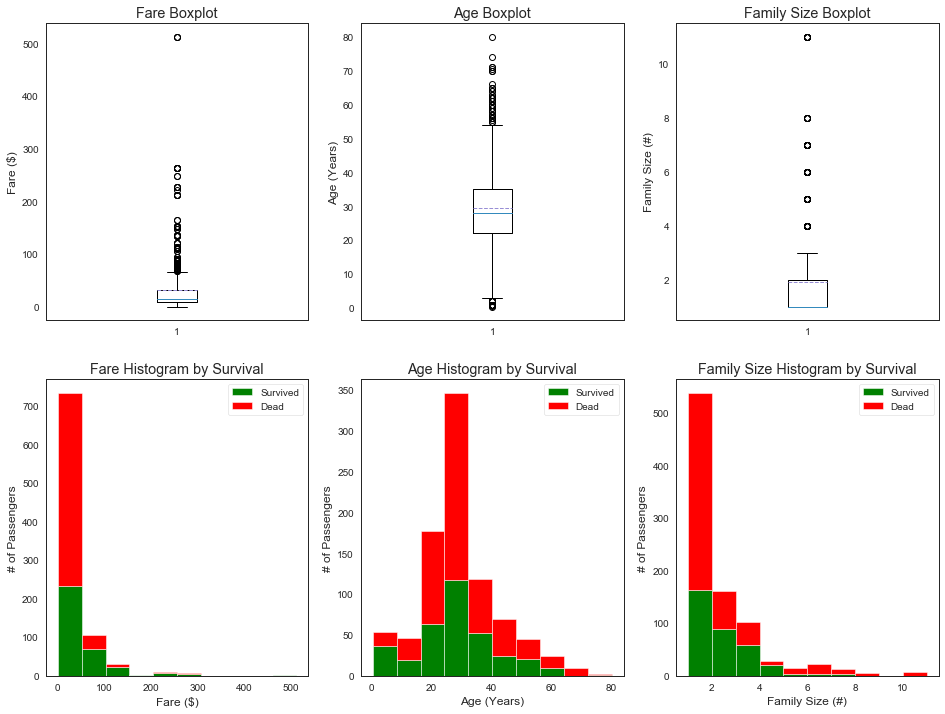

In [14]:
#Important: Intentionally plotted different ways for learing purposes only

#graph distribution of quantitative data
plt.figure(figsize=[16,12])

plt.subplot(231) #the number 231 are parameters same as 2,3,1 who are the positions
plt.boxplot(x=data1['Fare'],showmeans=True, meanline=True)
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(data1['Age'],showmeans=True, meanline=True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

plt.subplot(233)
plt.boxplot(data1['FamilySize'],showmeans=True, meanline=True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

plt.subplot(234)
plt.hist(x= [data1[data1['Survived']==1]['Fare'],data1[data1['Survived']==0]['Fare']],stacked=True, color=['g','r'],label=['Survived','Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x=[data1[data1['Survived']==1]['Age'],data1[data1['Survived']==0]['Age']],stacked=True, color=['g','r'],label=['Survived','Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x=[data1[data1['Survived']==1]['FamilySize'],data1[data1['Survived']==0]['FamilySize']],stacked=True, color=['g','r'],label=['Survived','Dead'])
plt.title('Family Size Histogram by Survival')
plt.xlabel('Family Size (#)')
plt.ylabel('# of Passengers')
plt.legend()

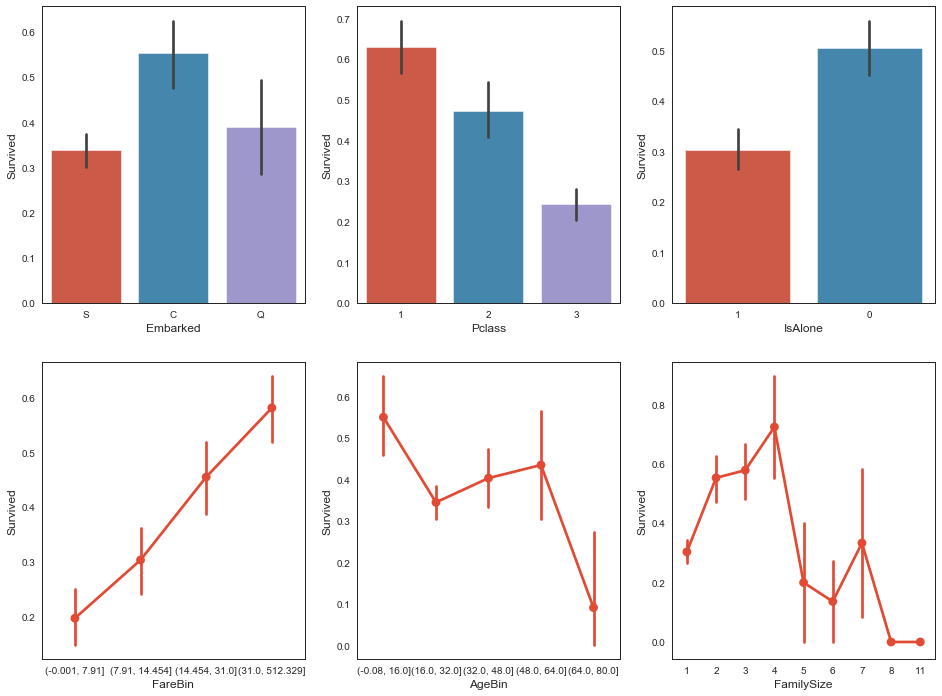

In [15]:
#we will use seaborn graphics for multi-variable comparision
#graph individual features by survival

fig, saxis = plt.subplots(2,3,figsize=(16,12))

sns.barplot(x= 'Embarked',y= 'Survived',data=data1, ax= saxis[0,0])

sns.barplot(x= 'Pclass', y= 'Survived', order=[1,2,3], data=data1, ax= saxis[0,1])

sns.barplot(x= 'IsAlone', y= 'Survived', order=[1,0], data=data1, ax= saxis[0,2])

sns.pointplot(x= 'FareBin', y='Survived', data=data1, ax=saxis[1,0])

sns.pointplot(x='AgeBin',y='Survived',data=data1,ax=saxis[1,1])

sns.pointplot(x='FamilySize',y='Survived',data=data1,ax=saxis[1,2])


Text(0.5, 1.0, 'Pclass vs Family Size Survival Comparison')

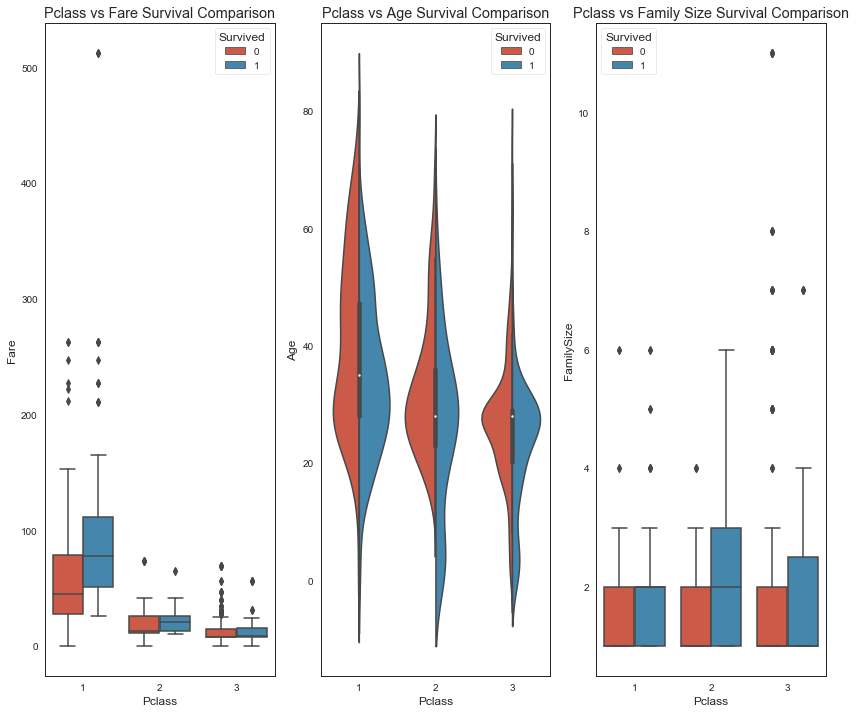

In [16]:
#graph distribution of qualitative data: pclass
#we know class mattered in survival, now let's compare class and a 2nd feature
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(14,12))

sns.boxplot(x='Pclass', y='Fare', hue='Survived',data=data1,ax=axis1)
axis1.set_title('Pclass vs Fare Survival Comparison')

sns.violinplot(x='Pclass',y='Age', hue='Survived',data=data1,split=True,ax=axis2)
axis2.set_title('Pclass vs Age Survival Comparison')

sns.boxplot(x='Pclass', y='FamilySize',hue='Survived',data=data1,ax=axis3)
axis3.set_title('Pclass vs Family Size Survival Comparison')

Text(0.5, 1, 'Sex vs IsAlone Survival Comparison')

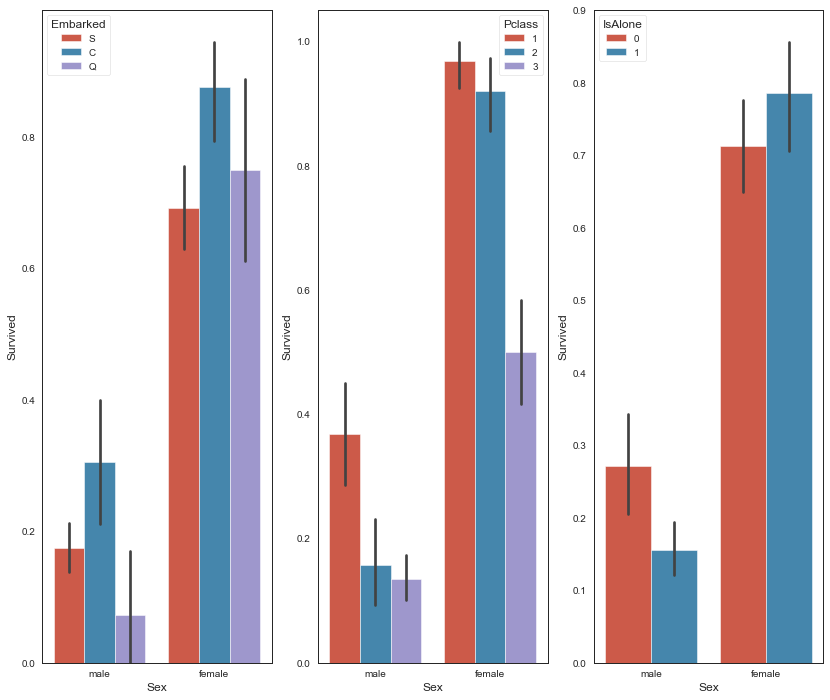

In [17]:
#graph distribution of qualitative data: Sex
#we know sex mattered in survival in titanic so let's compare sex and other features

fig, qaxis = plt.subplots(1,3,figsize=(14,12))

sns.barplot(x='Sex',y='Survived',hue='Embarked',data=data1,ax=qaxis[0])
axis1.set_title('Sex vs Emabrked Survival Comparison')

sns.barplot(x='Sex',y='Survived',hue='Pclass',data=data1,ax=qaxis[1])
axis1.set_title('Sex vs Pclas Survival Comparison')

sns.barplot(x='Sex',y='Survived',hue='IsAlone',data=data1,ax=qaxis[2])
axis1.set_title('Sex vs IsAlone Survival Comparison')

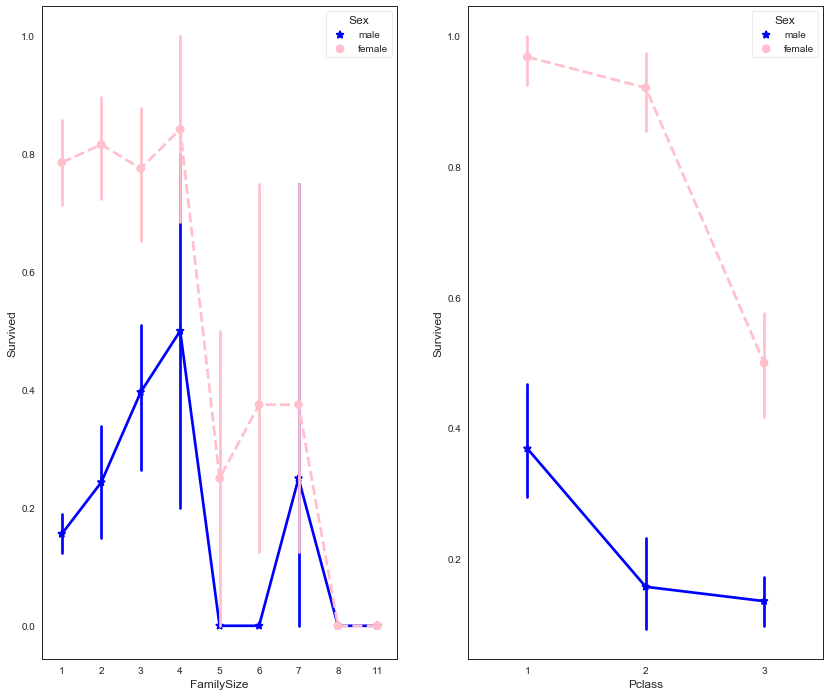

In [18]:
fig,(maxis1,maxis2)=plt.subplots(1,2,figsize=(14,12))

#how does family size factor with sex and survival compare

sns.pointplot(x='FamilySize',y='Survived',hue='Sex',data=data1,palette={'male':'blue','female':'pink'},markers=['*','o'],linestyles=['-','--'],ax=maxis1)

#how does class factor with sex and survival compare

sns.pointplot(x='Pclass',y='Survived',hue='Sex',data=data1,palette={'male':'blue','female':'pink'},markers=['*','o'],linestyles=['-','--'],ax=maxis2)


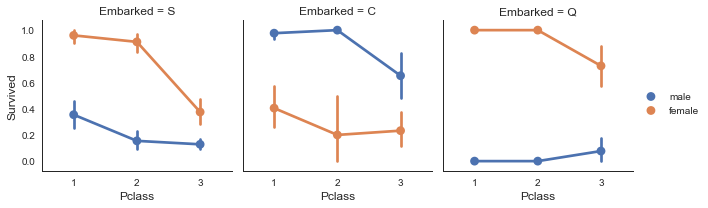

In [19]:
#how does embark port factor with class,sex and surviavl compare using facet grid

e = sns.FacetGrid(data1,col='Embarked')
e.map(sns.pointplot,'Pclass','Survived','Sex',ci=95.0,palette='deep')
e.add_legend()

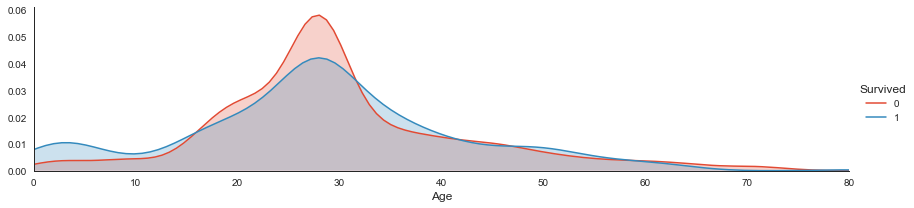

In [20]:
#plot distribution of age of passengers who survived or did not survive

a=sns.FacetGrid(data1,hue='Survived',aspect=4)
a.map(sns.kdeplot,'Age',shade=True)
a.set(xlim=(0,data1['Age'].max()))
a.add_legend()


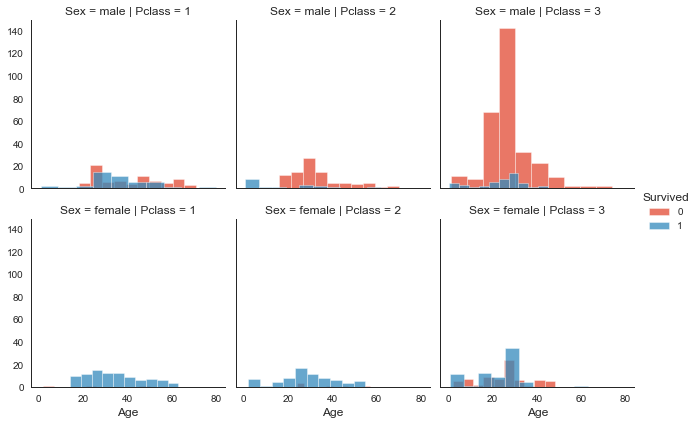

In [21]:
#histogram comparison of sex,class and age by survival
h = sns.FacetGrid(data1,row='Sex',col='Pclass',hue='Survived' )
h.map(plt.hist,'Age',alpha=.75)
h.add_legend()

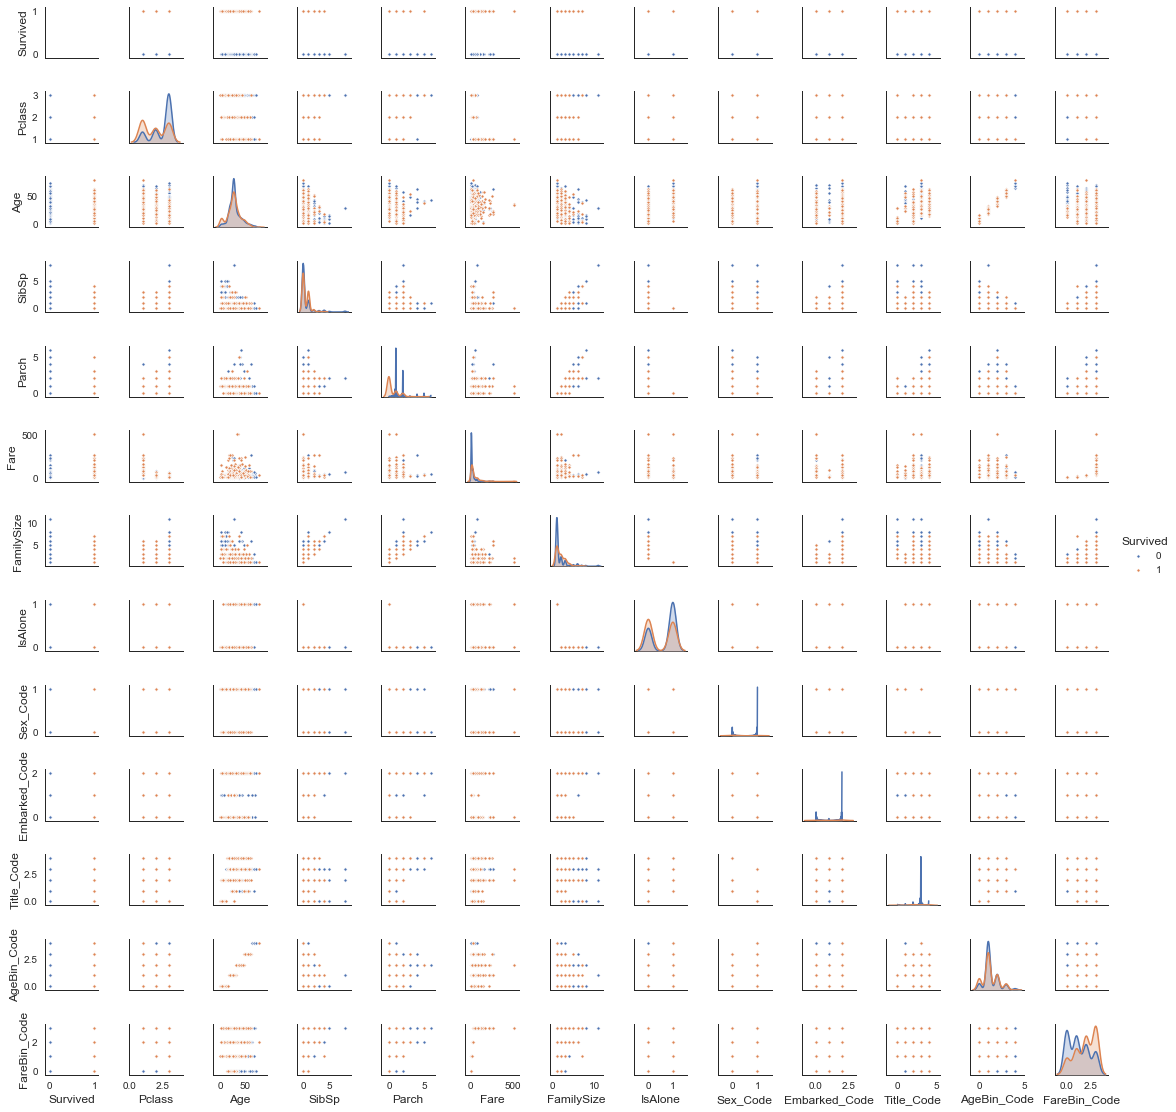

In [22]:
#pairplot of entire dataset
pp = sns.pairplot(data1, hue = 'Survived', palette = 'deep', size=1.2, diag_kind = 'kde',diag_kws = dict(shade=True), plot_kws = dict(s=10))
#pp.set(xticklabels=[])


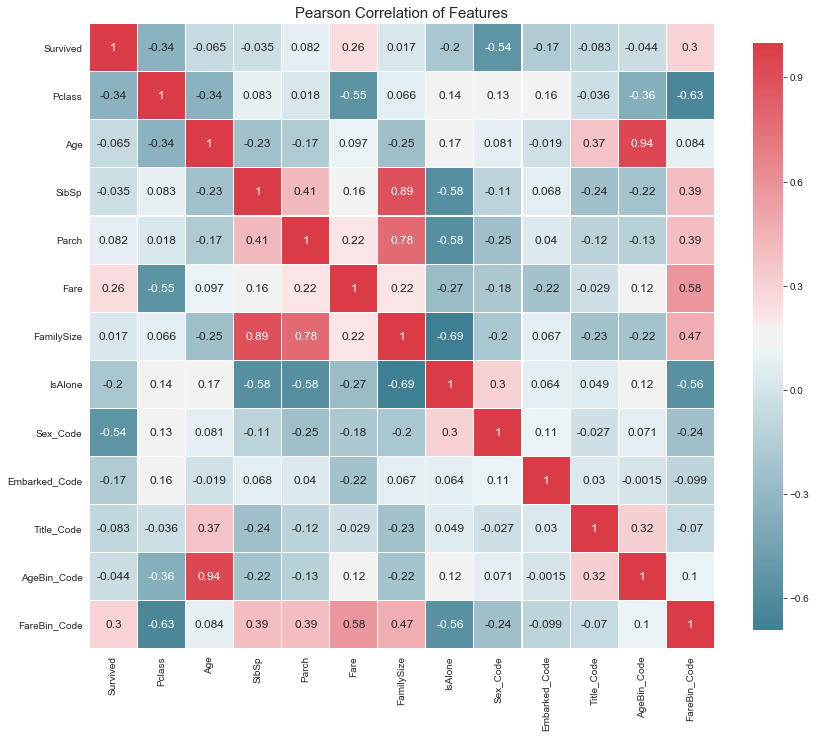

In [23]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize=(14,12))
    colormap = sns.diverging_palette(220,10,as_cmap=True)
    
    _ = sns.heatmap(df.corr(),cmap=colormap,square=True,cbar_kws={'shrink':.9},ax=ax,annot=True,linewidth=0.1,vmax=1.0,linecolor='white',annot_kws={'fontsize':12})
    
    plt.title('Pearson Correlation of Features', y=1.05,size=15)
    
correlation_heatmap(data1)
    

Next Step: Model Data

Machine learning can be categorized as: supervised learning, unsupervised learning, and reinforced learning. Supervised learning is where you train the model by presenting it a training dataset that includes the correct answer. Unsupervised learning is where you train the model using a training dataset that does not include the correct answer. And reinforced learning is a hybrid of the previous two, where the model is not given the correct answer immediately, but later after a sequence of events to reinforce learning. We are doing supervised machine learning, because we are training our algorithm by presenting it with a set of features and their corresponding target. We then hope to present it a new subset from the same dataset and have similar results in prediction accuracy.

There are many machine learning algorithms, however they can be reduced to four categories: classification, regression, clustering, or dimensionality reduction, depending on your target variable and data modeling goals. We'll save clustering and dimension reduction for another day, and focus on classification and regression. We can generalize that a continuous target variable requires a regression algorithm and a discrete target variable requires a classification algorithm. One side note, logistic regression, while it has regression in the name, is really a classification algorithm. Since our problem is predicting if a passenger survived or did not survive, this is a discrete target variable. We will use a classification algorithm from the sklearn library to begin our analysis. We will use cross validation and scoring metrics, discussed in later sections, to rank and compare our algorithms’ performance.

Now what is the best ML algorithm? for this we must learn NFLT(No Free Lunch Theorem) of ML. In short NFLT states that there is no super algorithm that works best in all situations for all datasets so the best approach is to try multiple MLAs tune them compare them for the. specific scenario.

Trees, Bagging, Random Forests and Boosting are different implementation of decision tree which is easier to learn than SVC.

Next step is to give an overview of how to run and compare several MLAs, but the rest of the kernals will focus on learning data modeling via decision trees and it's derivatives

In [24]:
#Machine Learning ALgorithm(MLA) Selection and Initialization

MLA= [
    #ensemble methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    #Gaussian processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #NaivesBayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #NearestNeigbour
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    #xgboost
    XGBClassifier()
]

#split dataset in cross validation with splitter class. It's an alternative to train_test_split
#we cross validate to find out the best parameters for our model

cv_split = model_selection.ShuffleSplit(n_splits = 10,test_size= .3,train_size=0.6,random_state=0)
#run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name','MLA Parameters','MLA Train Accuracy Mean','MLA Test Accuracy Mean','MLA Test Accuracy 3*STD','MLA Time']
MLA_compare = pd.DataFrame(columns= MLA_columns)

#create table to compare MLA predictions
MLA_predict = data1[Target]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:
    
    #set name and parameters
    #The attribute __class__ is set to the type of the instance
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'MLA Name']= MLA_name
    MLA_compare.loc[row_index,'MLA Parameters']= str(alg.get_params())
    
    #score model with cross validation
    cv_results = model_selection.cross_validate(alg, data1[data1_x_bin], data1[Target],cv = cv_split,return_train_score=True)
    
    MLA_compare.loc[row_index,'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index,'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index,'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
    
    #if this is a non-bias random sample, then +/-3 standard deviations(std) from the mean, should statistically capture 99.7% of the subsets
    
    MLA_compare.loc[row_index,'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3
    #let's know the worst that can happen
    
    #save MLA predictions
    alg.fit(data1[data1_x_bin],data1[Target])
    MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])
    
    row_index+=1

MLA_compare.sort_values(by=['MLA Test Accuracy Mean'], ascending= False, inplace=True)

MLA_compare
    

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
21,XGBClassifier,"{'objective': 'binary:logistic', 'base_score':...",0.890449,0.826493,0.0617704,0.0853854
14,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.837266,0.826119,0.0453876,0.0505416
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.895131,0.823507,0.0658548,0.0120042
15,NuSVC,"{'cache_size': 200, 'class_weight': None, 'coe...",0.835768,0.822761,0.0493681,0.0450319
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.866667,0.822015,0.0529916,0.0720966
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.891573,0.822015,0.0548507,0.0122933
17,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.895131,0.820522,0.0504229,0.00491283
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.891011,0.819403,0.0518321,0.0159525
18,ExtraTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.895131,0.814925,0.0713614,0.00353329
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.850375,0.813806,0.0690863,0.00368166


Text(0, 0.5, 'Algorithm')

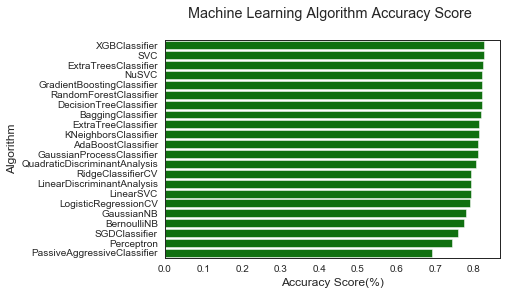

In [25]:
sns.barplot(x='MLA Test Accuracy Mean',y='MLA Name',data= MLA_compare, color='g')


plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score(%)')
plt.ylabel('Algorithm')



Evaluate Model Performance:

With some basic data cleaning, analysis, and machine learning algorithms(MLA),we are able to predict passenger survival with ~82% accuracy. But the important thing is can we do better and more importantly get an ROI(return on investment) for our time invested. For example if we are going to increase our accuracy by 1/10th of a percent, is it really worth 3-months of development. If you work in research maybe the answer is yes but if you work in business mostly the answer is no. So, keep that in mind when improving your model.

DataScience 101: Determine a Baseline Accuracy
Before we decide how to make our model better, let's determine if our model is even worth keeping. this is a binary problem that is the passenger survives or doesn't. So think of it like a coin flip. If you have a fair coin and you guessed heads or tail then you have a 50-50 chance of guessing correct. so, let's set 50% as the worst model performance because anything lower than that then why do i need you when i can just flip a coin.

Okay so with no information about the dataset we can always get 50% with a binary problem. But we have information about the dataset so we should be able to do better. we know that 1502/2224 or 67.5% of people died. Therefore, if we just predict the most frequent occurance that 100% of people died, then we would be right 67.5% of the time. So let's set 68% as bad model performance because again anything lower than that, then why do i need you when i can just predict using the most frequent occurance.

DataScience 101: How to create your own model
Our accuracy is increasing but can we do better? Are there any signals in our data? to illustrate this we're going to build our own decision tree model, because it is the easiest to conceptualize and requires simple addition and multiplication calculations. when creating a decision tree you want to ask questions that segment your target response, placing the survived/1 and dead/0 into homogenous subgroups. this is part science and part art, so let's play the 21 question game to show you how it works. 

Q1: Were you on the titanic?
if yes then majority(62% died). note our sample survival is different than our population of 68%. none the less if we assumed everybody died our sample accuracy is 62%

Question 2: Are you male or female? Male, majority (81%) died. Female, majority (74%) survived. Giving us an accuracy of 79%.

Question 3A (going down the female branch with count = 314): Are you in class 1, 2, or 3? Class 1, majority (97%) survived and Class 2, majority (92%) survived. Since the dead subgroup is less than 10, we will stop going down this branch. Class 3, is even at a 50-50 split. No new information to improve our model is gained.

Question 4A (going down the female class 3 branch with count = 144): Did you embark from port C, Q, or S? We gain a little information. C and Q, the majority still survived, so no change. Also, the dead subgroup is less than 10, so we will stop. S, the majority (63%) died. So, we will change females, class 3, embarked S from assuming they survived, to assuming they died. Our model accuracy increases to 81%.

Question 5A (going down the female class 3 embarked S branch with count = 88): So far, it looks like we made good decisions. Adding another level does not seem to gain much more information. This subgroup 55 died and 33 survived, since majority died we need to find a signal to identify the 33 or a subgroup to change them from dead to survived and improve our model accuracy. We can play with our features. One I found was fare 0-8, majority survived. It's a small sample size 11-9, but one often used in statistics. We slightly improve our accuracy, but not much to move us past 82%. So, we'll stop here.

Question 3B (going down the male branch with count = 577): Going back to question 2, we know the majority of males died. So, we are looking for a feature that identifies a subgroup that majority survived. Surprisingly, class or even embarked didn't matter like it did for females, but title does and gets us to 82%. Guess and checking other features, none seem to push us past 82%. So, we'll stop here for now.

You did it, with very little information, we get to 82% accuracy. On a worst, bad, good, better, and best scale, we'll set 82% to good, since it's a simple model that yields us decent results. But the question still remains, can we do better than our handmade model?

Before we do, let's code what we just wrote above. Please note, this is a manual process created by "hand." You won't have to do this, but it's important to understand it before you start working with MLA. Think of MLA like a TI-89 calculator on a Calculus Exam. It's very powerful and helps you with a lot of the grunt work. But if you don't know what you're doing on the exam, a calculator, even a TI-89, is not going to help you pass. So, study the next section wisely.




In [26]:
#coin flip model with random 1/survied 0/died
#iterate over dataframe rows as(index,series pairs):https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.iterrows.html

for index,row in data1.iterrows():
    if random.random()> 0.5: #random float x, 0.0<=x<=1.0
        data1.set_value(index,'Random_Predict',1)
    else:
        data1.set_value(index,'Random_Predict',0)

#score random guess of survival. Use shortcut 1= right guess and 0=wrong guess
#the mean of the coulmn will then equal the accuracy
data1['Random_Score'] = 0 #assume prediction wrong
data1.loc[(data1['Survived']==data1['Random_Predict']),'Random_Score']=1 #set to 1 for correct prediction

print('Coin Flip Model Accuracy: {:.2f}%'.format(data1['Random_Score'].mean()*100))

#also we can wrtie this with scikit
print('Coin Flip Model Accuracy with scikit: {:.2f}%'.format(metrics.accuracy_score(data1['Survived'],data1['Random_Predict'])*100))

Coin Flip Model Accuracy: 47.59%
Coin Flip Model Accuracy with scikit: 47.59%


In [30]:
#group by or pivot table:
pivot_female = data1[data1.Sex=='female'].groupby(['Sex','Pclass','Embarked','FareBin'])['Survived'].mean()
print('Survival Decision Tree w/Female Node: \n',pivot_female)

pivot_male = data1[data1.Sex=='male'].groupby(['Sex','Title'])['Survived'].mean()
print('\n\nSurvival Decision Tree w/Male Node: \n',pivot_male)


Survival Decision Tree w/Female Node: 
 Sex     Pclass  Embarked  FareBin        
female  1       C         (14.454, 31.0]     0.666667
                          (31.0, 512.329]    1.000000
                Q         (31.0, 512.329]    1.000000
                S         (14.454, 31.0]     1.000000
                          (31.0, 512.329]    0.955556
        2       C         (7.91, 14.454]     1.000000
                          (14.454, 31.0]     1.000000
                          (31.0, 512.329]    1.000000
                Q         (7.91, 14.454]     1.000000
                S         (7.91, 14.454]     0.875000
                          (14.454, 31.0]     0.916667
                          (31.0, 512.329]    1.000000
        3       C         (-0.001, 7.91]     1.000000
                          (7.91, 14.454]     0.428571
                          (14.454, 31.0]     0.666667
                Q         (-0.001, 7.91]     0.750000
                          (7.91, 14.454]     0.500000


In [32]:
#handmade model using brain power
def mytree(df):
    
    #initialize table to store predictions
    Model = pd.DataFrame(data = {'Predict':[]})
    male_title = ['Master'] #survived titles
    
    for index,row in df.iterrows():
        
        Model.loc[index,'Predict']=0
        
        if(df.loc[index,'Sex'] == 'female'):
            Model.loc[index,'Predict']=1
            
        if((df.loc[index,'Sex']=='female') &
           (df.loc[index,'Pclass']==3) & 
           (df.loc[index,'Embarked']=='S') &
           (df.loc[index,'Fare']>8)
          ):
            
            Model.loc[index,'Predict'] = 0
            
        if((df.loc[index,'Sex']=='male')&
           (df.loc[index,'Title'] in male_title)
          ):
            Model.loc[index,'Predict']=1
            
    return Model

Tree_Predict = mytree(data1)
print('Decision Tree Model Accuracy/Precision Score: {:.2f}% \n'.format(metrics.accuracy_score(data1['Survived'], Tree_Predict)*100))

#where recall score = (true positives)/(true positives +false negative) w/1 being best
#and F1 score = weighted average of precision and recall w/1 being best

print(metrics.classification_report(data1['Survived'],Tree_Predict))

Decision Tree Model Accuracy/Precision Score: 82.04% 

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       549
           1       0.82      0.68      0.75       342

    accuracy                           0.82       891
   macro avg       0.82      0.79      0.80       891
weighted avg       0.82      0.82      0.82       891



Confusion matrix, without normalization
[[497  52]
 [108 234]]
Normalized confusion matrix
[[0.91 0.09]
 [0.32 0.68]]


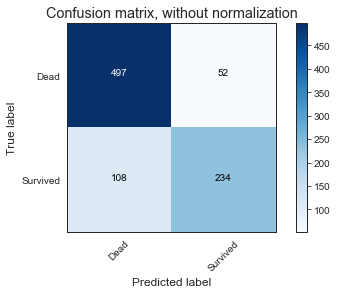

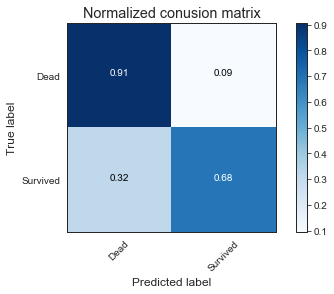

In [35]:
#plot accuracy summary
import itertools
def plot_confusion_matrix(cm, classes, normalize = False, title='Confusion matrix',cmap=plt.cm.Blues):
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2.
    
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment='center',color='white' if cm[i,j]>thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cnf_matrix = metrics.confusion_matrix(data1['Survived'],Tree_Predict)

np.set_printoptions(precision=2)
    
class_names =['Dead','Survived']
plt.figure()
plot_confusion_matrix(cnf_matrix,classes=class_names,title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize=True,title='Normalized conusion matrix')

    
            

Model Performance with Cross-Validation (CV):

Remember, it's important we use a different subset for train data to build our model and test data to evaluate our model. Otherwise, our model will be overfitted. Meaning it's great at "predicting" data it's already seen, but terrible at predicting data it has not seen; which is not prediction at all. It's like cheating on a school quiz to get 100%, but then when you go to take the exam, you fail because you never truly learned anything. The same is true with machine learning.

CV is basically a shortcut to split and score our model multiple times, so we can get an idea of how well it will perform on unseen data. It’s a little more expensive in computer processing, but it's important so we don't gain false confidence. This is helpful in a Kaggle Competition or any use case where consistency matters and surprises should be avoided.

In addition to CV, we used a customized sklearn train test splitter, to allow a little more randomness in our test scoring.

Tune Model with Hyper-Parameters:
When we used sklearn Decision Tree (DT) Classifier, we accepted all the function defaults. This leaves opportunity to see how various hyper-parameter settings will change the model accuracy. (Click here to learn more about parameters vs hyper-parameters.)

However, in order to tune a model, we need to actually understand it. That's why I took the time in the previous sections to show you how predictions work. Now let's learn a little bit more about our DT algorithm.

Credit: sklearn

Some advantages of decision trees are:

Simple to understand and to interpret. Trees can be visualized.
Requires little data preparation. Other techniques often require data normalization, dummy variables need to be created and blank values to be removed. Note however that this module does not support missing values.
The cost of using the tree (i.e., predicting data) is logarithmic in the number of data points used to train the tree.
Able to handle both numerical and categorical data. Other techniques are usually specialized in analyzing datasets that have only one type of variable. See algorithms for more information.
Able to handle multi-output problems.
Uses a white box model. If a given situation is observable in a model, the explanation for the condition is easily explained by Boolean logic. By contrast, in a black box model (e.g., in an artificial neural network), results may be more difficult to interpret.
Possible to validate a model using statistical tests. That makes it possible to account for the reliability of the model.
Performs well even if its assumptions are somewhat violated by the true model from which the data were generated.
The disadvantages of decision trees include:

Decision-tree learners can create over-complex trees that do not generalize the data well. This is called overfitting. Mechanisms such as pruning (not currently supported), setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.
Decision trees can be unstable because small variations in the data might result in a completely different tree being generated. This problem is mitigated by using decision trees within an ensemble.
The problem of learning an optimal decision tree is known to be NP-complete under several aspects of optimality and even for simple concepts. Consequently, practical decision-tree learning algorithms are based on heuristic algorithms such as the greedy algorithm where locally optimal decisions are made at each node. Such algorithms cannot guarantee to return the globally optimal decision tree. This can be mitigated by training multiple trees in an ensemble learner, where the features and samples are randomly sampled with replacement.
There are concepts that are hard to learn because decision trees do not express them easily, such as XOR, parity or multiplexer problems.
Decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the dataset prior to fitting with the decision tree.

Below are available hyper-parameters and defintions:

class sklearn.tree.DecisionTreeClassifier(criterion=’gini’, splitter=’best’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort=False)

We will tune our model using ParameterGrid, GridSearchCV, and customized sklearn scoring; click here to learn more about ROC_AUC scores. We will then visualize our tree with graphviz. Click here to learn more about ROC_AUC scores.

In [41]:
#base model
dtree = tree.DecisionTreeClassifier(random_state = 0)
base_results = model_selection.cross_validate(dtree, data1[data1_x_bin], data1[Target], cv  = cv_split,return_train_score=True)
dtree.fit(data1[data1_x_bin], data1[Target])

print('BEFORE DT Parameters: ', dtree.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
#print("BEFORE DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)


#tune hyper-parameters: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              #'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              #'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              #'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              #'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation
             }

#print(list(model_selection.ParameterGrid(param_grid)))

#choose best model with grid_search: #http://scikit-learn.org/stable/modules/grid_search.html#grid-search
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split,return_train_score=True)
tune_model.fit(data1[data1_x_bin], data1[Target])

#print(tune_model.cv_results_.keys())
#print(tune_model.cv_results_['params'])
print('AFTER DT Parameters: ', tune_model.best_params_)
#print(tune_model.cv_results_['mean_train_score'])
print("AFTER DT Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(tune_model.cv_results_['mean_test_score'])
print("AFTER DT Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)


#duplicates gridsearchcv
#tune_results = model_selection.cross_validate(tune_model, data1[data1_x_bin], data1[Target], cv  = cv_split)

#print('AFTER DT Parameters: ', tune_model.best_params_)
#print("AFTER DT Training w/bin set score mean: {:.2f}". format(tune_results['train_score'].mean()*100)) 
#print("AFTER DT Test w/bin set score mean: {:.2f}". format(tune_results['test_score'].mean()*100))
#print("AFTER DT Test w/bin set score min: {:.2f}". format(tune_results['test_score'].min()*100))
#print('-'*10)

BEFORE DT Parameters:  {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
BEFORE DT Training w/bin score mean: 89.51
BEFORE DT Test w/bin score mean: 82.09
BEFORE DT Test w/bin score 3*std: +/- 5.57
----------
AFTER DT Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
AFTER DT Training w/bin score mean: 89.35
AFTER DT Test w/bin score mean: 87.40
AFTER DT Test w/bin score 3*std: +/- 5.00
----------


Tune model with feature selection 
we will use recursive feature elimination (RFE) with cross validation(CV).


In [48]:
#base model
print('BEFORE DT RFE Training Shape Old: ',data1[data1_x_bin].shape)
print('BEFORE DT RFE Training Coulmns Old: ',data1[data1_x_bin].columns.values)

print('BEFORE DT RFE Training w/bin score mean: {:.2f}'.format(base_results['train_score'].mean()*100))

print('BEFORE DT RFE Test w/bin score mean: {:.2f}'.format(base_results['test_score'].mean()*100))
print('BEFORE DT RFE Test w/bin score 3*std: +/- {:.2f}'.format(base_results['test_score'].std()*100*3))
print('-'*20)

#feature selection
dtree_rfe = feature_selection.RFECV(dtree, step = 1, scoring = 'accuracy',cv=cv_split)
dtree_rfe.fit(data1[data1_x_bin], data1[Target])

#transform x&y to reduced features and fit new model
#alternative: can use pipeline to reduce fit and transform steps
X_rfe = data1[data1_x_bin].columns.values[dtree_rfe.get_support()]
rfe_results = model_selection.cross_validate(dtree, data1[X_rfe], data1[Target],cv = cv_split,return_train_score=True)

#print(dtree_rfe.grid_scores_)
print('AFTER DT RFE Training Shape New: ', data1[X_rfe].shape)
print('AFTER DT RFE Training Columns New: ',X_rfe)

print('AFTER DT RFE Training w/bin score mean: {:.2f}'.format(rfe_results['train_score'].mean()*100))
print('AFTER DT RFE Test w/bin score mean: {:.2f}'.format(rfe_results['test_score'].mean()*100))
print('AFTER DT RFE Test w/bin score 3*std: +/- {:.2f}'.format(rfe_results['test_score'].std()*3*100))
print('-'*20)


#tune rfe model
rfe_tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(),param_grid=param_grid,scoring='roc_auc',cv =cv_split,return_train_score=True)
rfe_tune_model.fit(data1[X_rfe],data1[Target])

#print(rfe_tune_model.cv_results_.keys())
#print(rfe_tune_model.cv_results_['params'])
print('AFTER DT RFE Tuned Parameters: ',rfe_tune_model.best_params_)
#print(rfe_tune_model.cv_results_['mean_train_score'])
print('AFTER DT RFE Tuned Training w/bin score mean: {:.2f}'.format(rfe_tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100))
#print(rfe_tune_model.cv_results_['mean_test_score'])
print('AFTER DT RFE Tuned Test w/bin score mean: {:.2f}'.format(rfe_tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print('AFTER DT RFE Tuned Test w/bin score 3*std: +/- {:.2f}'.format(rfe_tune_model.cv_results_['std_test_score'][tune_model.best_index_]*3*100))
print('-'*20)



BEFORE DT RFE Training Shape Old:  (891, 7)
BEFORE DT RFE Training Coulmns Old:  ['Sex_Code' 'Pclass' 'Embarked_Code' 'Title_Code' 'FamilySize'
 'AgeBin_Code' 'FareBin_Code']
BEFORE DT RFE Training w/bin score mean: 89.51
BEFORE DT RFE Test w/bin score mean: 82.09
BEFORE DT RFE Test w/bin score 3*std: +/- 5.57
--------------------
AFTER DT RFE Training Shape New:  (891, 6)
AFTER DT RFE Training Columns New:  ['Sex_Code' 'Pclass' 'Title_Code' 'FamilySize' 'AgeBin_Code'
 'FareBin_Code']
AFTER DT RFE Training w/bin score mean: 88.16
AFTER DT RFE Test w/bin score mean: 83.06
AFTER DT RFE Test w/bin score 3*std: +/- 6.22
--------------------
AFTER DT RFE Tuned Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
AFTER DT RFE Tuned Training w/bin score mean: 89.39
AFTER DT RFE Tuned Test w/bin score mean: 87.34
AFTER DT RFE Tuned Test w/bin score 3*std: +/- 6.21
--------------------


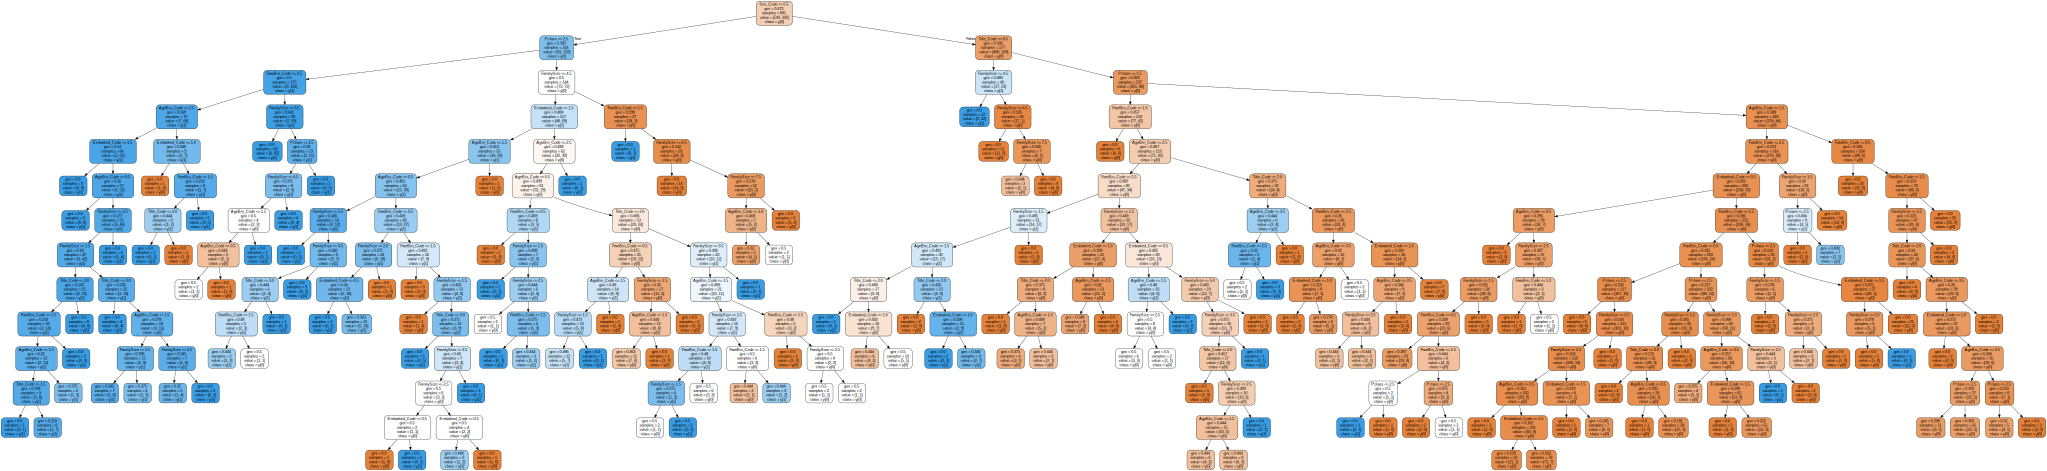

In [51]:
#graph MLA version of DT
import graphviz
dot_data = tree.export_graphviz(dtree, out_file=None,feature_names = data1_x_bin,class_names=True,filled=True,rounded=True)
graph= graphviz.Source(dot_data)
graph

Step 6: validate and implement

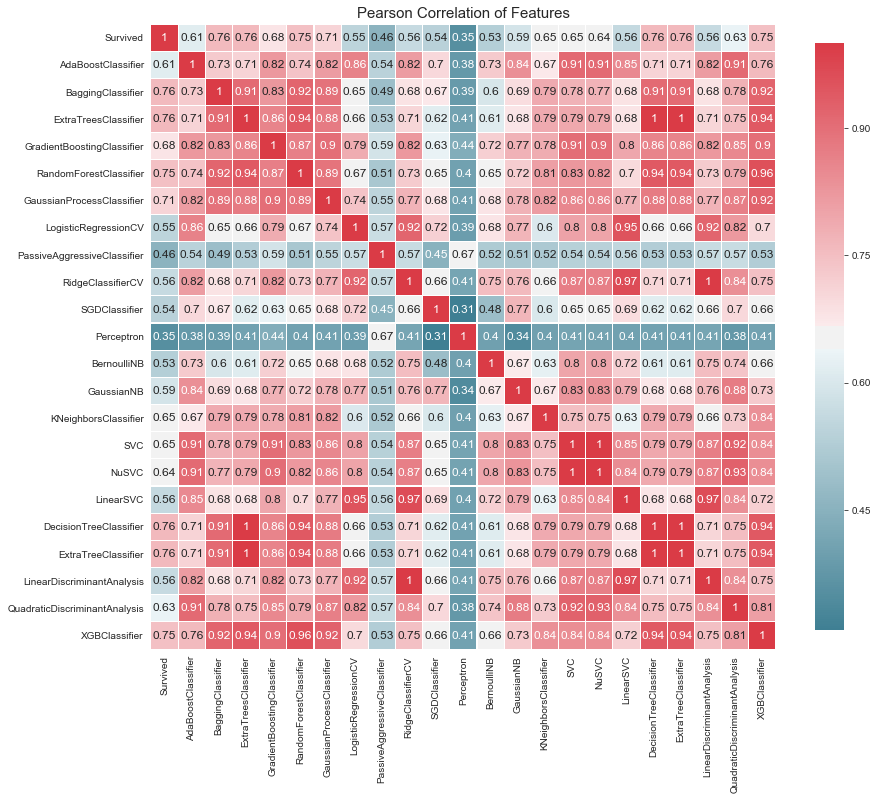

In [52]:
#compare algorithm predictions with each other where 1= exactly similar and 0= exactly opposite
#there are some 1's, but enough blues and light reds to create a super algo combining them

correlation_heatmap(MLA_predict)

In [58]:
#why choose one model when we can pick all with voting classifier
#removed models w/o attribute 'predict_proba' required for vote classifier and models with a 1.0 correlation to another mode 1
vote_est = [
    #ensemble methods
    ('ada',ensemble.AdaBoostClassifier()),
    ('bc',ensemble.BaggingClassifier()),
    ('etc',ensemble.ExtraTreesClassifier()),
    ('gbc',ensemble.GradientBoostingClassifier()),
    ('rfc',ensemble.RandomForestClassifier()),
    
    #gaussian process
    ('gpc', gaussian_process.GaussianProcessClassifier()),
    
    #GLM
    ('lr',linear_model.LogisticRegressionCV()),
    
    #naive bayes
    ('bnb', naive_bayes.BernoulliNB()),
    ('gnb', naive_bayes.GaussianNB()),
    
    #nearest neighbor
    ('knn', neighbors.KNeighborsClassifier()),
    
    #SVM
    ('svc', svm.SVC(probability=True)),
    
    #xgboost
    ('xgb',XGBClassifier())
]

#Hard Vote or majority rules
vote_hard = ensemble.VotingClassifier(estimators = vote_est, voting='hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, data1[data1_x_bin], data1[Target],cv=cv_split,return_train_score=True)
vote_hard.fit(data1[data1_x_bin],data1[Target])

print('Hard Voting Training w/bin score mean: {:.2f}'.format(vote_hard_cv['train_score'].mean()*100))
print('Hard Voting Test w/bin score mean: {:.2f}'.format(vote_hard_cv['test_score'].mean()*100))
print('Hard Voting Test w/bin score 3*std: +/- {:.2f}'.format(vote_hard_cv['test_score'].std()*100*3))
print('-'*20)

#soft vote or weighted probabilities
vote_soft = ensemble.VotingClassifier(estimators = vote_est, voting='soft')
vote_soft_cv = model_selection.cross_validate(vote_soft,data1[data1_x_bin],data1[Target],cv=cv_split,return_train_score=True)
vote_soft.fit(data1[data1_x_bin],data1[Target])

print('Soft Voting Training w/bin score mean: {:.2f}'.format(vote_soft_cv['train_score'].mean()*100))
print('Soft Voting Test w/bin score mean: {:.2f}'.format(vote_soft_cv['test_score'].mean()*100))
print('Soft Voting Test w/bin score 3*std: +/- {:.2f}'.format(vote_soft_cv['test_score'].std()*100*3))



Hard Voting Training w/bin score mean: 87.23
Hard Voting Test w/bin score mean: 82.20
Hard Voting Test w/bin score 3*std: +/- 4.53
--------------------
Soft Voting Training w/bin score mean: 87.81
Soft Voting Test w/bin score mean: 82.54
Soft Voting Test w/bin score 3*std: +/- 5.50


In [59]:
#hard vote or majority rules w/tuned hyperparameters
grid_hard = ensemble.VotingClassifier(estimators = vote_est,voting= 'hard')
grid_hard_cv = model_selection.cross_validate(grid_hard,data1[data1_x_bin],data1[Target],cv=cv_split,return_train_score=True)
grid_hard.fit(data1[data1_x_bin],data1[Target])

print('Hard Voting w/tuned HyperParameters Training w/bin score mean: {:.2f}'.format(grid_hard_cv['train_score'].mean()*100))
print('Hard Voting w/tuned HyperParameters Test w/bin score mean: {:.2f}'.format(grid_hard_cv['test_score'].mean()*100))
print('Hard Voting w/tuned HyperParameters Test w/bin score 3*std: +/- {:.2f}'.format(grid_hard_cv['test_score'].std()*100*3))
print('-'*20)

#soft vote or weighted probabilities w/tuned hyperparameters
grid_soft = ensemble.VotingClassifier(estimators = vote_est,voting= 'soft')
grid_soft_cv = model_selection.cross_validate(grid_soft,data1[data1_x_bin],data1[Target],cv=cv_split,return_train_score=True)
grid_soft.fit(data1[data1_x_bin],data1[Target])

print('Soft Voting w/tuned HyperParameters Training w/bin score mean: {:.2f}'.format(grid_soft_cv['train_score'].mean()*100))
print('Soft Voting w/tuned HyperParameters Test w/bin score mean: {:.2f}'.format(grid_soft_cv['test_score'].mean()*100))
print('Soft Voting w/tuned HyperParameters Test w/bin score 3*std: +/- {:.2f}'.format(grid_soft_cv['test_score'].std()*100*3))
print('-'*20)

#12/31/17 tuned with data1_x_bin
#The best parameter for AdaBoostClassifier is {'learning_rate': 0.1, 'n_estimators': 300, 'random_state': 0} with a runtime of 33.39 seconds.
#The best parameter for BaggingClassifier is {'max_samples': 0.25, 'n_estimators': 300, 'random_state': 0} with a runtime of 30.28 seconds.
#The best parameter for ExtraTreesClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'random_state': 0} with a runtime of 64.76 seconds.
#The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 34.35 seconds.
#The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 76.32 seconds.
#The best parameter for GaussianProcessClassifier is {'max_iter_predict': 10, 'random_state': 0} with a runtime of 6.01 seconds.
#The best parameter for LogisticRegressionCV is {'fit_intercept': True, 'random_state': 0, 'solver': 'liblinear'} with a runtime of 8.04 seconds.
#The best parameter for BernoulliNB is {'alpha': 0.1} with a runtime of 0.19 seconds.
#The best parameter for GaussianNB is {} with a runtime of 0.04 seconds.
#The best parameter for KNeighborsClassifier is {'algorithm': 'brute', 'n_neighbors': 7, 'weights': 'uniform'} with a runtime of 4.84 seconds.
#The best parameter for SVC is {'C': 2, 'decision_function_shape': 'ovo', 'gamma': 0.1, 'probability': True, 'random_state': 0} with a runtime of 29.39 seconds.
#The best parameter for XGBClassifier is {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300, 'seed': 0} with a runtime of 46.23 seconds.
#Total optimization time was 5.56 minutes.

Hard Voting w/tuned HyperParameters Training w/bin score mean: 87.21
Hard Voting w/tuned HyperParameters Test w/bin score mean: 81.94
Hard Voting w/tuned HyperParameters Test w/bin score 3*std: +/- 4.04
--------------------
Soft Voting w/tuned HyperParameters Training w/bin score mean: 87.87
Soft Voting w/tuned HyperParameters Test w/bin score mean: 82.61
Soft Voting w/tuned HyperParameters Test w/bin score 3*std: +/- 4.75
--------------------


In [62]:
# prepare data for modeling
print(data_val.info())
print('-'*20)

#handmade decision tree -submission score = 0.77990
data_val['Survived'] = mytree(data_val).astype(int)

#decision tree w/full dataset modeling submission score: defaults= 0.76555, tuned= 0.77990
#submit_dt = tree.DecisionTreeClassifier()
#submit_dt = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
#submit_dt.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_dt.best_params_) #Best Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
#data_val['Survived'] = submit_dt.predict(data_val[data1_x_bin])


#bagging w/full dataset modeling submission score: defaults= 0.75119, tuned= 0.77990
#submit_bc = ensemble.BaggingClassifier()
#submit_bc = model_selection.GridSearchCV(ensemble.BaggingClassifier(), param_grid= {'n_estimators':grid_n_estimator, 'max_samples': grid_ratio, 'oob_score': grid_bool, 'random_state': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_bc.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_bc.best_params_) #Best Parameters:  {'max_samples': 0.25, 'n_estimators': 500, 'oob_score': True, 'random_state': 0}
#data_val['Survived'] = submit_bc.predict(data_val[data1_x_bin])


#extra tree w/full dataset modeling submission score: defaults= 0.76555, tuned= 0.77990
#submit_etc = ensemble.ExtraTreesClassifier()
#submit_etc = model_selection.GridSearchCV(ensemble.ExtraTreesClassifier(), param_grid={'n_estimators': grid_n_estimator, 'criterion': grid_criterion, 'max_depth': grid_max_depth, 'random_state': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_etc.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_etc.best_params_) #Best Parameters:  {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'random_state': 0}
#data_val['Survived'] = submit_etc.predict(data_val[data1_x_bin])


#random foreset w/full dataset modeling submission score: defaults= 0.71291, tuned= 0.73205
#submit_rfc = ensemble.RandomForestClassifier()
#submit_rfc = model_selection.GridSearchCV(ensemble.RandomForestClassifier(), param_grid={'n_estimators': grid_n_estimator, 'criterion': grid_criterion, 'max_depth': grid_max_depth, 'random_state': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_rfc.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_rfc.best_params_) #Best Parameters:  {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'random_state': 0}
#data_val['Survived'] = submit_rfc.predict(data_val[data1_x_bin])



#ada boosting w/full dataset modeling submission score: defaults= 0.74162, tuned= 0.75119
#submit_abc = ensemble.AdaBoostClassifier()
#submit_abc = model_selection.GridSearchCV(ensemble.AdaBoostClassifier(), param_grid={'n_estimators': grid_n_estimator, 'learning_rate': grid_ratio, 'algorithm': ['SAMME', 'SAMME.R'], 'random_state': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_abc.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_abc.best_params_) #Best Parameters:  {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 300, 'random_state': 0}
#data_val['Survived'] = submit_abc.predict(data_val[data1_x_bin])


#gradient boosting w/full dataset modeling submission score: defaults= 0.75119, tuned= 0.77033
#submit_gbc = ensemble.GradientBoostingClassifier()
#submit_gbc = model_selection.GridSearchCV(ensemble.GradientBoostingClassifier(), param_grid={'learning_rate': grid_ratio, 'n_estimators': grid_n_estimator, 'max_depth': grid_max_depth, 'random_state':grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_gbc.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_gbc.best_params_) #Best Parameters:  {'learning_rate': 0.25, 'max_depth': 2, 'n_estimators': 50, 'random_state': 0}
#data_val['Survived'] = submit_gbc.predict(data_val[data1_x_bin])

#extreme boosting w/full dataset modeling submission score: defaults= 0.73684, tuned= 0.77990
#submit_xgb = XGBClassifier()
#submit_xgb = model_selection.GridSearchCV(XGBClassifier(), param_grid= {'learning_rate': grid_learn, 'max_depth': [0,2,4,6,8,10], 'n_estimators': grid_n_estimator, 'seed': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_xgb.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_xgb.best_params_) #Best Parameters:  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300, 'seed': 0}
#data_val['Survived'] = submit_xgb.predict(data_val[data1_x_bin])


#hard voting classifier w/full dataset modeling submission score: defaults= 0.75598, tuned = 0.77990
#data_val['Survived'] = vote_hard.predict(data_val[data1_x_bin])

data_val['Survived'] = grid_hard.predict(data_val[data1_x_bin])

#soft voting classifier w/full dataset modeling submission score: defaults= 0.73684, tuned = 0.74162
#data_val['Survived'] = vote_soft.predict(data_val[data1_x_bin])
#data_val['Survived'] = grid_soft.predict(data_val[data1_x_bin])


#submit file
submit = data_val[['PassengerId','Survived']]
submit.to_csv('/Users/hrishkeshhandique/Desktop/python projects/Titanic- ML from Disaster/titanic/submit.csv',index=False)

print('Validation Data Distribution: \n',data_val['Survived'].value_counts(normalize=True))
submit.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 22 columns):
PassengerId      418 non-null int64
Pclass           418 non-null int64
Name             418 non-null object
Sex              418 non-null object
Age              418 non-null float64
SibSp            418 non-null int64
Parch            418 non-null int64
Ticket           418 non-null object
Fare             418 non-null float64
Cabin            91 non-null object
Embarked         418 non-null object
FamilySize       418 non-null int64
IsAlone          418 non-null int64
Title            418 non-null object
FareBin          418 non-null category
AgeBin           418 non-null category
Sex_Code         418 non-null int64
Embarked_Code    418 non-null int64
Title_Code       418 non-null int64
AgeBin_Code      418 non-null int64
FareBin_Code     418 non-null int64
Survived         418 non-null int64
dtypes: category(2), float64(2), int64(12), object(6)
memory usage: 66.3+ KB
None
------

,PassengerId,Survived
278,1170,0
171,1063,0
359,1251,1
314,1206,1
170,1062,0
90,982,1
114,1006,1
323,1215,1
351,1243,0
297,1189,1
